<a href="https://colab.research.google.com/github/UnplugCharger/DATA-IMPUTATION-USING-AUTOENCODERS/blob/master/DATA_IMPUTATION_USING_AUTOENCODERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconstruction error
Our reconstruction error will be the mean squared error which hopefully will work for categorical data. Since we are using Keras, our function must adhere to some rules.

# Importing  the Libraries

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.objectives import mse
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
from keras.regularizers import l1_l2 
from collections import defaultdict

In [2]:
%matplotlib inline

In [3]:
def make_reconstruction_loss(n_features):
    def reconstruction_loss(input_and_mask, y_pred):
        X_values = input_and_mask[:, :n_features]
        X_values.name = "$X_values"
        missing_mask = input_and_mask[:, n_features:]
        missing_mask.name = "$missing_mask"
        observed_mask = 1 - missing_mask
        observed_mask.name = "$observed_mask"
        X_values_observed = X_values * observed_mask
        X_values_observed.name = "$X_values_observed"
        pred_observed = y_pred * observed_mask
        pred_observed.name = "$y_pred_observed"
        return mse(y_true=X_values_observed, y_pred=pred_observed)
    return reconstruction_loss

Aditionaly we will modify the mean squared error function so that it takes into account the mask  of the input data

In [4]:
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))

# Model Creation

Our NN has 3 hidden layers (with ReLU activation functions) with dropout probability set to 0.5. You can also choose two regularizers coefficients - the sum of the weights (L1) and sum the squares of the weights (L2). These are 0. The activation function for the output layer is sigmoid. It appears to work better than linear for our use case.

In [26]:

class Autoencoder:
    def __init__(self, data,
                 recurrent_weight=0.5,
                 optimizer="adam",
                 dropout_probability=0.5,
                 hidden_activation="relu",
                 output_activation="sigmoid",
                 init="glorot_normal",
                 l1_penalty=0,
                 l2_penalty=0):
        self.data = data.copy()
        self.recurrent_weight = recurrent_weight
        self.optimizer = optimizer
        self.dropout_probability = dropout_probability
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.init = init
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty


    def _get_hidden_layer_sizes(self):
        n_dims = self.data.shape[1]
        return [
            min(2000, 8 * n_dims),
            min(500, 2 * n_dims),
            int(np.ceil(0.5 * n_dims)),
        ]
    
    
    def _create_model(self):
        hidden_layer_sizes = self._get_hidden_layer_sizes()
        first_layer_size = hidden_layer_sizes[0]
        n_dims = self.data.shape[1]
        model = Sequential()
        model.add(Dense(
            first_layer_size,
            input_dim= 2 * n_dims,
            activation=self.hidden_activation,
            W_regularizer=l1l2(self.l1_penalty, self.l2_penalty),
            init=self.init))
        model.add(Dropout(self.dropout_probability))
        for layer_size in hidden_layer_sizes[1:]:
            model.add(Dense(
                layer_size,
                activation=self.hidden_activation,
                W_regularizer=l1_l2(self.l1_penalty, self.l2_penalty),
                init=self.init))
            model.add(Dropout(self.dropout_probability))
        model.add(Dense(
            n_dims,
            activation=self.output_activation,
            W_regularizer=l1_l2(self.l1_penalty, self.l2_penalty),
            init=self.init))
        loss_function = make_reconstruction_loss(n_dims)
        model.compile(optimizer=self.optimizer, loss=loss_function)
        return model
    
    
    def fill(self, missing_mask):
        self.data[missing_mask] = -1
    
    
    def _create_missing_mask(self):
        if self.data.dtype != "f" and self.data.dtype != "d":
            self.data = self.data.astype(float)
        return np.isnan(self.data)
    
    
    def _train_epoch(self, model, missing_mask, batch_size):
        input_with_mask = np.hstack([self.data, missing_mask])
        n_samples = len(input_with_mask)
        n_batches = int(np.ceil(n_samples / batch_size))
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_shuffled = input_with_mask[indices]
        for batch_idx in range(n_batches):
            batch_start = batch_idx * batch_size
            batch_end = (batch_idx + 1) * batch_size
            batch_data = X_shuffled[batch_start:batch_end, :]
            model.train_on_batch(batch_data, batch_data)
        return model.predict(input_with_mask)
    
    
    def train(self, batch_size=256, train_epochs=100):
        missing_mask = self._create_missing_mask()
        self.fill(missing_mask)
        self.model = self._create_model()
        observed_mask = ~missing_mask
        for epoch in range(train_epochs):
            X_pred = self._train_epoch(self.model, missing_mask, batch_size)
            observed_mae = masked_mae(X_true=self.data,
                                    X_pred=X_pred,
                                    mask=observed_mask)
            if epoch % 50 == 0:
                print("observed mae:", observed_mae)
            old_weight = (1.0 - self.recurrent_weight)
            self.data[missing_mask] *= old_weight
            pred_missing = X_pred[missing_mask]
            self.data[missing_mask] += self.recurrent_weight * pred_missing
        return self.data.copy()

#  Here is a diagram of our model:



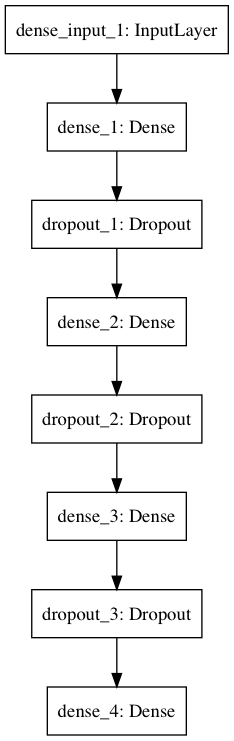

In [8]:
from IPython.display import Image
Image('/content/autoencoder.png')

# Evaluation

##Preparing the data
We will use the encoding technique for our categorical data as discussed above. Let’s load (and drop a column with missing values from) our dataset.

In [9]:
df = pd.read_csv("/content/mushrooms.csv")

In [10]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [11]:
def sniff(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['sample'] = df.iloc[0]
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        return info.sort_values('data type')

In [12]:
sniff(df)

,sample,data type,percent missing
class,p,object,0.0
spore-print-color,k,object,0.0
ring-type,p,object,0.0
ring-number,o,object,0.0
veil-color,w,object,0.0
veil-type,p,object,0.0
stalk-color-below-ring,w,object,0.0
stalk-color-above-ring,w,object,0.0
stalk-surface-below-ring,s,object,0.0
stalk-surface-above-ring,s,object,0.0


We have a very clean dataset

##Making data dissapear
We will use MCAR as a driving process behind making missing data. Each data point in our dataset has 0.1 probability of being set to NaN.

In [14]:
prob_missing = 0.1
df_incomplete = df.copy()
ix = [(row, col) for row in range(df.shape[0]) for col in range(df.shape[1])]
for row, col in random.sample(ix, int(round(prob_missing * len(ix)))):
    df_incomplete.iat[row, col] = np.nan

In [15]:
missing_encoded = pd.get_dummies(df_incomplete)
for col in df.columns:
    missing_cols = missing_encoded.columns.str.startswith(str(col) + "_")
    missing_encoded.loc[df_incomplete[col].isnull(), missing_cols] = np.nan

##Encoding
Let’s one-hot encode our dataset using panda’s get_dummies and apply our missing data points accordingly:

In [27]:
imputer = Autoencoder(missing_encoded.values)
complete_encoded = imputer.train(train_epochs=300, batch_size=256)

NameError: ignored